Mounted at /content/drive
['Auditorium_152_preprocessed.csv', 'Classroom_210_preprocessed.csv', 'Classroom_230_preprocessed.csv', 'Kendeda_Building_Auditorium_152_0c8b95e42928_27_Feb_2025_02_Mar_2025.csv', 'Kendeda_Building_Classroom_210_0c8b95e37bf4_27_Feb_2025_02_Mar_2025.csv', 'Kendeda_Building_Classroom_230_24d7eb23b7d4_27_Feb_2025_02_Mar_2025.csv']

=== /content/drive/MyDrive/VIP Data/Auditorium_152_preprocessed.csv ===
Data Shape: (1700, 20)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
[LSTM]
MSE: 0.0015634775276796619
RMSE: 0.03954083367456561
R2 : -0.011359879949744522
[Random Forest]
MSE : 0.0014102930652283914
RMSE: 0.03755386884501238
R2  : 0.08772988425352157


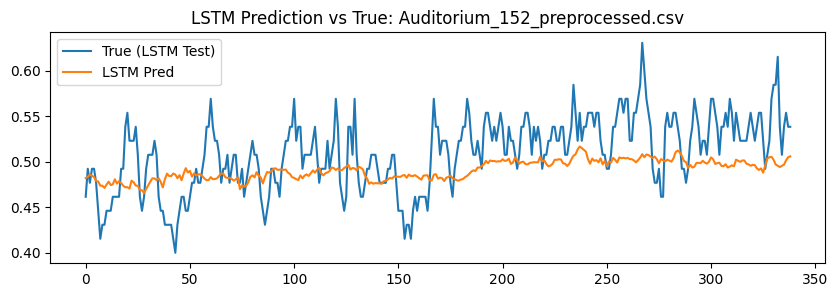

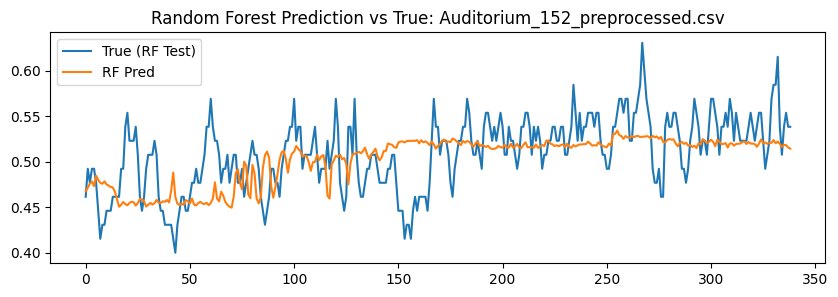


=== /content/drive/MyDrive/VIP Data/Classroom_210_preprocessed.csv ===
Data Shape: (1988, 20)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
[LSTM]
MSE: 0.001622644739734343
RMSE: 0.04028206474020843
R2 : -13.760279963170447
[Random Forest]
MSE : 0.00019485241459156003
RMSE: 0.013958954638208409
R2  : -0.7724620309323231


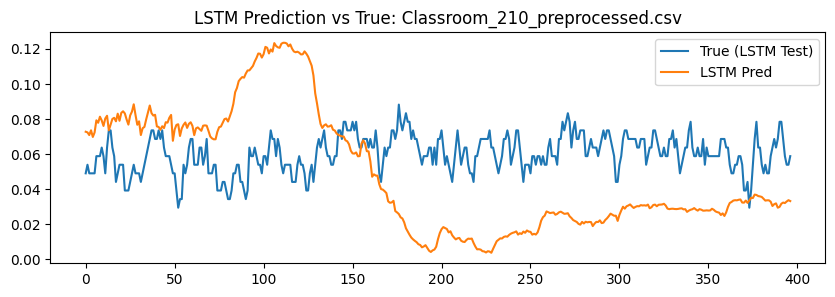

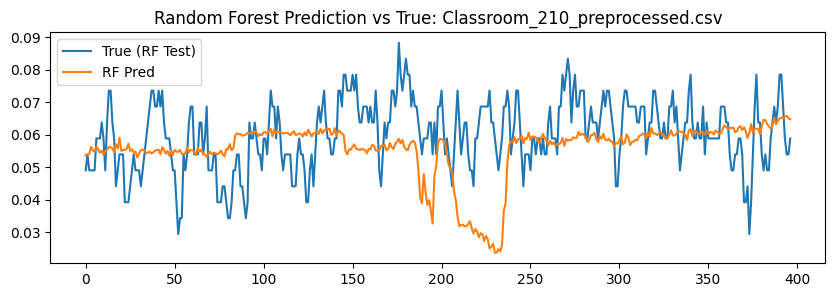


=== /content/drive/MyDrive/VIP Data/Classroom_230_preprocessed.csv ===
Data Shape: (2045, 20)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[LSTM]
MSE: 0.005693805261180266
RMSE: 0.07545730753996108
R2 : -57.13619956453826
[Random Forest]
MSE : 0.024048943157971136
RMSE: 0.1550772167598166
R2  : -244.55004862569402


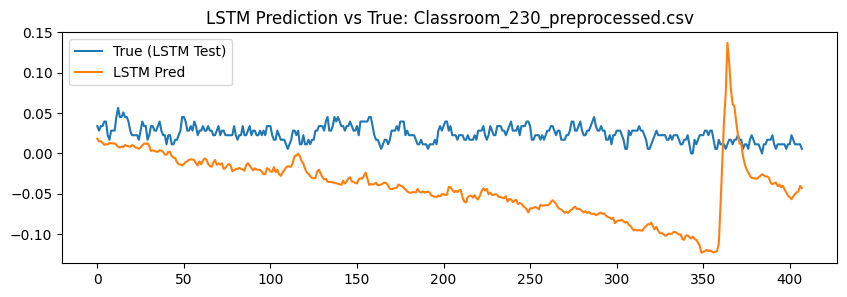

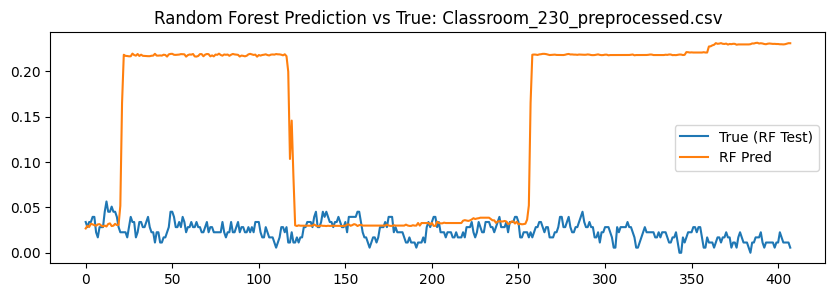

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import os
print(os.listdir("/content/drive/MyDrive/VIP Data"))

!pip install scikit-learn tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

files = [
    "/content/drive/MyDrive/VIP Data/Auditorium_152_preprocessed.csv",
    "/content/drive/MyDrive/VIP Data/Classroom_210_preprocessed.csv",
    "/content/drive/MyDrive/VIP Data/Classroom_230_preprocessed.csv"
]

target_col = 'co2_ppm'
window_size = 5

def make_lstm_dataset(df, feature_cols, target_col, window_size=5):
    X_list = []
    y_list = []
    values = df[feature_cols].values
    target = df[target_col].values
    for i in range(len(df) - window_size):
        X_list.append(values[i : i+window_size])
        y_list.append(target[i + window_size])
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

def make_rf_dataset(df, feature_cols, target_col, window_size=5):
    dataset = []
    target_list = []
    feats = df[feature_cols].values
    targs = df[target_col].values
    for i in range(len(df) - window_size):
        window_feats = feats[i : i+window_size].flatten()
        dataset.append(window_feats)
        target_list.append(targs[i + window_size])
    X_ = np.array(dataset)
    y_ = np.array(target_list)
    return X_, y_

for data_path in files:
    df = pd.read_csv(data_path, parse_dates=['dtm'])
    df = df.sort_values('dtm').reset_index(drop=True)
    print(f"\n=== {data_path} ===")
    print("Data Shape:", df.shape)

    feature_cols = df.columns.drop(['dtm', target_col])

    X_lstm, y_lstm = make_lstm_dataset(df, feature_cols, target_col, window_size)
    split_index = int(len(X_lstm) * 0.8)
    X_train, X_test = X_lstm[:split_index], X_lstm[split_index:]
    y_train, y_test = y_lstm[:split_index], y_lstm[split_index:]

    model_lstm = Sequential()
    model_lstm.add(LSTM(units=32, activation='tanh', return_sequences=False, input_shape=(window_size, len(feature_cols))))
    model_lstm.add(Dense(16, activation='relu'))
    model_lstm.add(Dense(1, activation='linear'))
    model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    history = model_lstm.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=32,
        verbose=0
    )

    y_pred_lstm = model_lstm.predict(X_test)
    mse_lstm = mean_squared_error(y_test, y_pred_lstm)
    rmse_lstm = np.sqrt(mse_lstm)
    r2_lstm = r2_score(y_test, y_pred_lstm)

    print("[LSTM]")
    print("MSE:", mse_lstm)
    print("RMSE:", rmse_lstm)
    print("R2 :", r2_lstm)

    X_rf, y_rf = make_rf_dataset(df, feature_cols, target_col, window_size)
    split_index_rf = int(len(X_rf)*0.8)
    X_train_rf, X_test_rf = X_rf[:split_index_rf], X_rf[split_index_rf:]
    y_train_rf, y_test_rf = y_rf[:split_index_rf], y_rf[split_index_rf:]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_rf, y_train_rf)
    y_pred_rf = rf.predict(X_test_rf)

    mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    r2_rf = r2_score(y_test_rf, y_pred_rf)

    print("[Random Forest]")
    print("MSE :", mse_rf)
    print("RMSE:", rmse_rf)
    print("R2  :", r2_rf)

    plt.figure(figsize=(10,3))
    plt.plot(y_test, label='True (LSTM Test)')
    plt.plot(y_pred_lstm, label='LSTM Pred')
    plt.title(f"LSTM Prediction vs True: {data_path.split('/')[-1]}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,3))
    plt.plot(y_test_rf, label='True (RF Test)')
    plt.plot(y_pred_rf, label='RF Pred')
    plt.title(f"Random Forest Prediction vs True: {data_path.split('/')[-1]}")
    plt.legend()
    plt.show()